<a href="https://colab.research.google.com/github/threewisemonkeys-as/dl_fun/blob/master/atari_env_rl/pacman_screen_as_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import math
import random
import itertools
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
env = gym.make('MsPacman-v0').unwrapped

### Define NN architecture

In [0]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - kernel_size) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))




### Define function to get screenshot

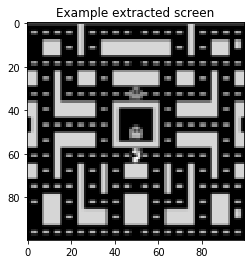

In [0]:
proccess_screen = T.Compose([
    T.ToPILImage(),
    T.Lambda(lambda img: T.functional.crop(img, 0, 5, 170, 150)),
    T.Grayscale(),
    T.Resize([100, 100]),
    T.ToTensor(),
    T.Lambda(lambda img: img.unsqueeze(0).to(device)),
])

def view_screen(screen, title='Screen'):
    plt.figure()
    plt.clf()
    plt.imshow(proccess_screen(screen).squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.show()

    
view_screen(env.reset(), title='Example extracted screen')

In [0]:
proccess_screen(env.reset()).shape

torch.Size([1, 1, 100, 100])

### Initialize NNs and other utitlities

In [0]:
# Custom tuple to store each transition
Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Get screen dimensions
_, _, screen_height, screen_width = proccess_screen(env.reset()).shape

# Instatiate policy and target NNs.
policy_net = DQN(screen_height, screen_width, env.action_space.n).to(device)
target_net = DQN(screen_height, screen_width, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=2592, out_features=9, bias=True)
)

In [0]:
def optimize_model(memory, optimizer, BATCH_SIZE, GAMMA, losses):
    
    # Dont update model until replay memory has enough elements
    if len(memory) < BATCH_SIZE:
        return
    
    # Get random sample batch from replay memory
    transitions = random.sample(memory, BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
        
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), 
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    losses.append(loss)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Clip gradients 
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [0]:
def train(num_episodes, optimizer,
          REPLAY_MEMORY_SIZE, BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TARGET_UPDATE,
          verbose=False, animation=False):
    
    # Memory to store previous experiences
    memory = collections.deque(maxlen=REPLAY_MEMORY_SIZE)
    
    # Tracking variables
    steps_done = 0
    step_wise_scores = []
    episode_wise_scores = []
    losses = []

    for i_episode in range(num_episodes):
        print(f"Running Episode {i_episode + 1}/{num_episodes} ...")
        
        # Initialize the environment and state
        state = proccess_screen(env.reset())
        episode_wise_scores.append(0)

        # Play single game
        for t in itertools.count():           
            
            # Select and perform an action using epsilon greedy
            steps_done += 1

            if EPS_DECAY is not None:
              EPS = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            else:
              EPS = EPS_START - (EPS_START - EPS_END) * (i_episode / num_episodes)

            if random.random() > EPS:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                 action = torch.tensor([[random.randrange(env.action_space.n)]], 
                                       device=device, dtype=torch.long)

            # Take action and record the reward from the environment
            current_screen, reward, done, _ = env.step(action.item())
            step_wise_scores.append(reward)
            episode_wise_scores[-1] += reward
            reward = torch.tensor([reward], device=device)
            next_state = proccess_screen(current_screen)
            
            # Store the transition in memory
            memory.append(Transition(state, action, next_state, reward, done))

            # Move to the next state
            state = next_state

            # Update the target network, copying all weights and biases in DQN
            if steps_done % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # Perform one step of the optimization (on the target network)
            optimize_model(memory, optimizer, BATCH_SIZE, GAMMA, losses)
            
            # Render the gameplay
            if animation:
                env.render()
            
            # Log progress periodically
            if (t + 1) % 100 == 0 and verbose:
                print(f" - Reward after {t + 1} steps is {episode_wise_scores[-1]}")
            
            # Break from loop if done
            if done:
                break
                
        print(f"> Score for Episode {i_episode + 1} = {episode_wise_scores[-1]} after completing {t + 1} steps. | Running Average = {(sum(episode_wise_scores) / len(episode_wise_scores)):.1f}\n")
        
    if animation:
        env.close()
        
    print('\nTraining complete!')

In [0]:
def test_net(num_episodes, verbose=False, animation=False):
    
    episode_wise_scores = []
    step_wise_scores = []
    
    for i_episode in range(num_episodes):
        print(f"Running {i_episode + 1}/{num_episodes} ...")
        
        # Initialize the environment and state
        state = proccess_screen(env.reset())
        episode_wise_scores.append(0)

        # Play single game
        for t in itertools.count():
            
            # Select action
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1)
                    
            # Take action and record the reward from the environment
            current_screen, reward, done, _ = env.step(action.item())
            step_wise_scores.append(reward)
            episode_wise_scores[-1] += reward
            reward = torch.tensor([reward], device=device)
            next_state = proccess_screen(current_screen)

            # Move to the next state
            state = next_state
            
            # Render the gameplay
            if animation:
                env.render()
            
            # Log progress periodically
            if (t + 1) % 100 == 0 and verbose:
                print(f" - Reward after {t} steps is {episode_wise_scores[-1]}")

            if done:
                break

        print(f"> Score for Episode {i_episode} = {episode_wise_scores[-1]} | Running Average = {(sum(episode_wise_scores) / len(episode_wise_scores)):.1f}\n")

    if animation:
        env.close()
    
    print(f"\nComplete | Average score = {sum(episode_wise_scores) / len(episode_wise_scores)}")

In [0]:
def test_random(num_episodes, verbose=False, animation=False):
    episode_wise_scores = []
    step_wise_scores = []
    
    for i_episode in range(num_episodes):
        print(f"Running {i_episode + 1}/{num_episodes} ...")
        
        # Initialize the environment and state
        state = proccess_screen(env.reset())
        episode_wise_scores.append(0)

        # Play single game
        for t in itertools.count():
            
            # Select action
            with torch.no_grad():
                action = random.randrange(env.action_space.n)
                    
            # Take action and record the reward from the environment
            current_screen, reward, done, _ = env.step(action)
            step_wise_scores.append(reward)
            episode_wise_scores[-1] += reward
            reward = torch.tensor([reward], device=device)
            next_state = proccess_screen(current_screen)

            # Move to the next state
            state = next_state
            
            # Render the gameplay
            if animation:
                env.render()
            
            # Log progress periodically
            if (t + 1) % 100 == 0 and verbose:
                print(f" - Reward after {t} steps is {episode_wise_scores[-1]}")

            if done:
                break

        print(f"> Score for Episode {i_episode} = {episode_wise_scores[-1]} | Running Average = {(sum(episode_wise_scores) / len(episode_wise_scores)):.1f}\n")

    if animation:
        env.close()
    
    print(f"\nComplete | Average score = {sum(episode_wise_scores) / len(episode_wise_scores)}")

In [0]:
train(num_episodes=10,
      optimizer=optim.RMSprop(policy_net.parameters()),
      REPLAY_MEMORY_SIZE=10_000,
      BATCH_SIZE=128,
      GAMMA=0.95,
      EPS_START=0.9,
      EPS_END=0.1,
      EPS_DECAY=None,
      TARGET_UPDATE=50,
      verbose=True,
      animation=False)

Running Episode 1/10 ...
 - Reward after 100 steps is 10.0
 - Reward after 200 steps is 50.0
 - Reward after 300 steps is 100.0
 - Reward after 400 steps is 120.0
 - Reward after 500 steps is 160.0
> Score for Episode 1 = 190.0 after completing 582 steps. | Running Average = 190.0

Running Episode 2/10 ...
 - Reward after 100 steps is 10.0
 - Reward after 200 steps is 50.0
 - Reward after 300 steps is 50.0
 - Reward after 400 steps is 110.0
 - Reward after 500 steps is 110.0
> Score for Episode 2 = 160.0 after completing 586 steps. | Running Average = 175.0

Running Episode 3/10 ...
 - Reward after 100 steps is 20.0
 - Reward after 200 steps is 80.0
 - Reward after 300 steps is 100.0
 - Reward after 400 steps is 160.0
 - Reward after 500 steps is 210.0
 - Reward after 600 steps is 220.0
 - Reward after 700 steps is 240.0
> Score for Episode 3 = 240.0 after completing 736 steps. | Running Average = 196.7

Running Episode 4/10 ...
 - Reward after 100 steps is 10.0
 - Reward after 200 ste

In [0]:
test_net(10)

NameError: ignored

In [0]:
test_random(10)

Running 1/10 ...
> Score for Episode 0 = 310.0 | Running Average = 310.0

Running 2/10 ...
> Score for Episode 1 = 160.0 | Running Average = 235.0

Running 3/10 ...
> Score for Episode 2 = 160.0 | Running Average = 210.0

Running 4/10 ...
> Score for Episode 3 = 200.0 | Running Average = 207.5

Running 5/10 ...
> Score for Episode 4 = 150.0 | Running Average = 196.0

Running 6/10 ...
> Score for Episode 5 = 230.0 | Running Average = 201.7

Running 7/10 ...
> Score for Episode 6 = 190.0 | Running Average = 200.0

Running 8/10 ...
> Score for Episode 7 = 340.0 | Running Average = 217.5

Running 9/10 ...
> Score for Episode 8 = 240.0 | Running Average = 220.0

Running 10/10 ...
> Score for Episode 9 = 190.0 | Running Average = 217.0


Complete | Average score = 217.0


In [0]:
from google.colab import files
def download_policy_net():
  torch.save(policy_net.state_dict(), 'checkpoint.pth')
  files.download('checkpoint.pth')